<a href="https://colab.research.google.com/github/miit-daga/DriftGuard-ETC/blob/main/DriftGuard_ETC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn matplotlib tqdm
print("Libraries installed!")

Libraries installed!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
base_path = "/content/drive/MyDrive"

In [ ]:
import os
folder_path = "/content/drive/MyDrive/CICIDS2017"
print(os.listdir(folder_path))

['.ipynb_checkpoints', 'Wednesday-workingHours.pcap_ISCX.csv', 'Tuesday-WorkingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [ ]:
# Load Thursday's data and print columns
attack_file = '/content/drive/MyDrive/CICIDS2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv'
attack_data = pd.read_csv(attack_file, nrows=1)  # Load just 1 row to check columns
print("Columns in Thursday's data:", attack_data.columns.tolist())

Columns in Thursday's data: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' 

In [ ]:
# Load Monday's data (BENIGN)
file_path = '/content/drive/MyDrive/CICIDS2017/Monday-WorkingHours.pcap_ISCX.csv'
benign_data = pd.read_csv(file_path, nrows=50000)
benign_data.columns = benign_data.columns.str.strip()
benign_data = benign_data[benign_data['Label'] == 'BENIGN']
print("Benign data shape:", benign_data.shape)

Benign data shape: (50000, 79)


In [ ]:
import pandas as pd
print("Loading DDoS data (Friday)...")
attack_file = '/content/drive/MyDrive/CICIDS2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'
try:
    attack_data_ddos = pd.read_csv(attack_file, nrows=100000)
    attack_data_ddos.columns = attack_data_ddos.columns.str.strip()
    ddos_labels = ['DDoS']
    attack_data_ddos = attack_data_ddos[attack_data_ddos['Label'].isin(ddos_labels)].copy()

    print(f"Filtered DDoS data shape: {attack_data_ddos.shape}")
    if not attack_data_ddos.empty:
        print(f"  Sample DDoS labels found: {attack_data_ddos['Label'].unique()}")
    else:
        print("  Warning: No DDoS samples found with specified labels.")

except FileNotFoundError:
    print(f"Error: DDoS file not found at {attack_file}. Please check the path.")
    attack_data_ddos = pd.DataFrame()
print("\nLoading Web Attack data (Thursday)...")
thursday_file_path = '/content/drive/MyDrive/CICIDS2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv'

try:
    attack_data_thurs = pd.read_csv(thursday_file_path, nrows=200000)
    attack_data_thurs.columns = attack_data_thurs.columns.str.strip()

    web_attack_labels = [
        'Web Attack � Brute Force',
        'Web Attack � XSS',
        'Web Attack � Sql Injection',
        'Web Attack - Brute Force',
        'Web Attack - XSS',
        'Web Attack - Sql Injection'
    ]
    attack_data_web = attack_data_thurs[attack_data_thurs['Label'].isin(web_attack_labels)].copy()

    print(f"Filtered Web Attack data shape: {attack_data_web.shape}")
    if not attack_data_web.empty:
        print(f"  Sample Web Attack labels found: {attack_data_web['Label'].unique()}")
    else:
        print(f"  Warning: No Web Attacks found with labels {web_attack_labels}. Check labels/file path.")

except FileNotFoundError:
    print(f"Error: Thursday file not found at {thursday_file_path}. Please check the path.")
    attack_data_web = pd.DataFrame()

if benign_data.empty or attack_data_ddos.empty or attack_data_web.empty:
     if benign_data.empty: print("Error: benign_data is empty.")
     if attack_data_ddos.empty: print("Error: attack_data_ddos is empty.")
     if attack_data_web.empty: print("Error: attack_data_web is empty.")
     raise ValueError("One or more required data files could not be loaded/filtered correctly. Stopping execution.")
else:
    print("\nSuccessfully loaded samples for Benign, DDoS, and Web Attack classes.")

Loading DDoS data (Friday)...
Filtered DDoS data shape: (61194, 79)
  Sample DDoS labels found: ['DDoS']

Loading Web Attack data (Thursday)...
Filtered Web Attack data shape: (2180, 79)
  Sample Web Attack labels found: ['Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']

Successfully loaded samples for Benign, DDoS, and Web Attack classes.


In [ ]:
import pandas as pd
import numpy as np

print("\nCombining and balancing data across all loaded classes (using threshold undersampling)...")

data_frames_to_combine = [df for df in [benign_data, attack_data_ddos, attack_data_web] if not df.empty]

if not data_frames_to_combine:
    raise ValueError("No data available to combine after loading and filtering in previous cells.")

all_data = pd.concat(data_frames_to_combine, ignore_index=True)
print(f"Combined data shape before balancing: {all_data.shape}")
print("Class distribution before balancing:")
class_counts = all_data['Label'].value_counts()
print(class_counts)

undersampling_threshold = 10000
print(f"\nBalancing strategy: Undersample majority classes to max {undersampling_threshold}, keep all others.")

balanced_list = []
unique_labels_in_all_data = class_counts.index

for label in unique_labels_in_all_data:
    class_subset = all_data[all_data['Label'] == label]
    current_class_count = len(class_subset)

    if current_class_count > undersampling_threshold:
        sample_count = undersampling_threshold
        print(f"  Sampling {sample_count} instances for majority class: '{label}' (original: {current_class_count})")
        balanced_list.append(class_subset.sample(sample_count, random_state=42))
    elif current_class_count > 0:
        sample_count = current_class_count
        print(f"  Keeping all {sample_count} instances for minority/moderate class: '{label}'")
        balanced_list.append(class_subset)
    else:
        print(f"  Warning: Class '{label}' has 0 samples, skipping.")

if not balanced_list:
    raise ValueError("No data collected after attempting to balance classes. Check initial data loading and threshold.")

subset = pd.concat(balanced_list, ignore_index=True)

subset = subset.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nPreview of shuffled data (first 10 rows):")
print(subset[['Label']].head(20))

print("\nBalanced subset created!")
print(f"Total samples in balanced subset: {subset.shape[0]}")
print("Class distribution in balanced subset:")
print(subset['Label'].value_counts())



Combining and balancing data across all loaded classes (using threshold undersampling)...
Combined data shape before balancing: (113374, 79)
Class distribution before balancing:
Label
DDoS                          61194
BENIGN                        50000
Web Attack � Brute Force       1507
Web Attack � XSS                652
Web Attack � Sql Injection       21
Name: count, dtype: int64

Balancing strategy: Undersample majority classes to max 10000, keep all others.
  Sampling 10000 instances for majority class: 'DDoS' (original: 61194)
  Sampling 10000 instances for majority class: 'BENIGN' (original: 50000)
  Keeping all 1507 instances for minority/moderate class: 'Web Attack � Brute Force'
  Keeping all 652 instances for minority/moderate class: 'Web Attack � XSS'
  Keeping all 21 instances for minority/moderate class: 'Web Attack � Sql Injection'

Preview of shuffled data (first 10 rows):
                       Label
0   Web Attack � Brute Force
1                     BENIGN
2     

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
features = [
    'Flow Duration',               # Duration of the flow
    'Total Fwd Packets',           # Number of packets from source to destination
    'Total Backward Packets',      # Number of packets from destination to source
    'Flow Bytes/s',                # Data rate (sudden spikes indicate attacks)
    'Flow Packets/s',              # Packet rate
    'Packet Length Mean',          # Average packet size
    'Fwd Packet Length Mean',      # Forward packet size consistency
    'Bwd Packet Length Mean',      # Backward packet size consistency
    'Active Mean',                 # Time a flow is active
    'Idle Mean'                    # Time a flow is idle
]

subset.columns = subset.columns.str.strip()

data = subset[features + ['Label']].copy()

data.replace([np.inf, -np.inf], np.nan, inplace=True)

original_indices = data.index
rows_before_drop = data.shape[0]
data = data.dropna()
rows_after_drop = data.shape[0]
print(f"Dropped {rows_before_drop - rows_after_drop} rows due to NaN/Inf values in selected features.")
valid_indices = data.index
y_labels_text = subset.loc[valid_indices, 'Label'].copy()
X = data[features]
print("\nFitting LabelEncoder and storing mapping...")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels_text)

label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print(f"Label mapping created: {label_mapping}")
print(f"Unique numerical labels in y: {np.unique(y)}")
print(f"Shape of X after cleaning: {X.shape}")
print(f"Shape of y after cleaning: {y.shape}")
X = X.reset_index(drop=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
num_classes = len(np.unique(y))
print(f"\nTotal number of unique classes detected: {num_classes}")


print("\nPreprocessing complete!")
print(f"Final X_scaled shape: {X_scaled.shape}, Final y shape: {y.shape}")
print("Class distribution AFTER cleaning (numerical labels):")
print(pd.Series(y).value_counts())

Dropped 10 rows due to NaN/Inf values in selected features.

Fitting LabelEncoder and storing mapping...
Label mapping created: {0: 'BENIGN', 1: 'DDoS', 2: 'Web Attack � Brute Force', 3: 'Web Attack � Sql Injection', 4: 'Web Attack � XSS'}
Unique numerical labels in y: [0 1 2 3 4]
Shape of X after cleaning: (22170, 10)
Shape of y after cleaning: (22170,)

Total number of unique classes detected: 5

Preprocessing complete!
Final X_scaled shape: (22170, 10), Final y shape: (22170,)
Class distribution AFTER cleaning (numerical labels):
1    10000
0     9990
2     1507
4      652
3       21
Name: count, dtype: int64


Dataset split: 17736 training samples, 4434 test samples.
Initializing and training XGBoost classifier (multi-class)...
XGBoost Classifier trained!
Training accuracy: 96.81%
Test accuracy: 96.50%
Test Precision (weighted): 96.26%
Test Recall (weighted): 96.50%
Test F1-score (weighted): 95.98%
Test AUC (weighted OvR): 0.9981

Plotting Confusion Matrix for Initial Model on Test Set...


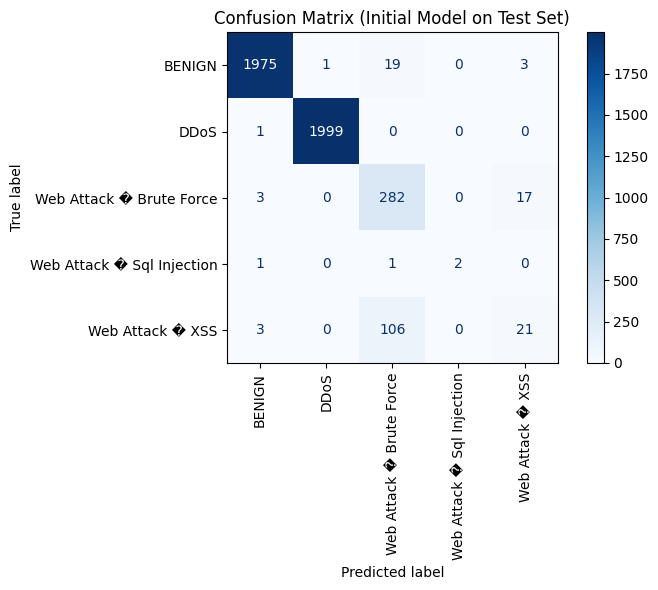

Initialized 'centroids_initial' and 'counts_initial' for drift detection.


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dataset split: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples.")

print("Initializing and training XGBoost classifier (multi-class)...")

clf = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', random_state=42)
clf.fit(X_train, y_train)
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print(f"XGBoost Classifier trained!")
print(f"Training accuracy: {train_accuracy:.2%}")
print(f"Test accuracy: {test_accuracy:.2%}")

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

n_classes = len(np.unique(y))
if n_classes > 2:
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
elif n_classes == 2:

     try:
        pos_label_idx = list(clf.classes_).index(1)
        auc = roc_auc_score(y_test, y_pred_proba[:, pos_label_idx])
     except ValueError:
        print("Warning: Class '1' not found in clf.classes_. Cannot calculate binary AUC assuming 1 is positive.")
        auc = float('nan')
else:
    auc = float('nan')

print(f"Test Precision (weighted): {precision:.2%}")
print(f"Test Recall (weighted): {recall:.2%}")
print(f"Test F1-score (weighted): {f1:.2%}")
if not np.isnan(auc):
    print(f"Test AUC (weighted OvR): {auc:.4f}")

print("\nPlotting Confusion Matrix for Initial Model on Test Set...")
cm_initial = confusion_matrix(y_test, y_pred)
display_labels_initial = label_encoder.classes_ if 'label_encoder' in locals() else None

if display_labels_initial is not None:
    disp_initial = ConfusionMatrixDisplay(confusion_matrix=cm_initial, display_labels=display_labels_initial)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp_initial.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title("Confusion Matrix (Initial Model on Test Set)")
    plt.tight_layout()
    plt.show()
else:
    print("Warning: label_encoder not found. Cannot display class names on confusion matrix.")
    disp_initial = ConfusionMatrixDisplay(confusion_matrix=cm_initial)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp_initial.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title("Confusion Matrix (Initial Model on Test Set - Numerical Labels)")
    plt.tight_layout()
    plt.show()
if 'centroids' in locals() and 'counts' in locals():
    centroids_initial = {cls: np.copy(centroids[cls]) for cls in centroids}
    counts_initial = counts.copy()
    print("Initialized 'centroids_initial' and 'counts_initial' for drift detection.")
else:
    print("Error: 'centroids' or 'counts' not found. Cannot initialize for drift detection. Ensure centroid initialization cell was run.")

In [ ]:
import numpy as np

centroids = {}
counts = {}
initial_centroid_samples = 100
print(f"Initializing centroids using up to the first {initial_centroid_samples} samples of each class...")
unique_labels_initial = np.unique(y)

for cls in unique_labels_initial:
    class_indices = np.where(y == cls)[0]
    if len(class_indices) > 0:
        num_samples_to_use = min(len(class_indices), initial_centroid_samples)
        initial_class_indices = class_indices[:num_samples_to_use]
        initial_class_samples = X_scaled[initial_class_indices]
        centroids[cls] = np.mean(initial_class_samples, axis=0)
        counts[cls] = num_samples_to_use

        class_name = label_mapping.get(cls, f"Unknown({cls})")
        print(f"  Initialized centroid for class '{class_name}' ({cls}) using {num_samples_to_use} samples.")
    else:
        class_name = label_mapping.get(cls, f"Unknown({cls})")
        print(f"Warning: No samples found for class '{class_name}' ({cls}) in the final dataset 'y'. Cannot initialize centroid.")


centroids_initial = {cls: np.copy(centroids[cls]) for cls in centroids}

print(f"\nInitial centroids generated for {len(centroids)} classes.")
print(f"Initial counts set for classes (numerical labels): {counts}")

Initializing centroids using up to the first 100 samples of each class...
  Initialized centroid for class 'BENIGN' (0) using 100 samples.
  Initialized centroid for class 'DDoS' (1) using 100 samples.
  Initialized centroid for class 'Web Attack � Brute Force' (2) using 100 samples.
  Initialized centroid for class 'Web Attack � Sql Injection' (3) using 21 samples.
  Initialized centroid for class 'Web Attack � XSS' (4) using 100 samples.

Initial centroids generated for 5 classes.
Initial counts set for classes (numerical labels): {np.int64(0): 100, np.int64(1): 100, np.int64(2): 100, np.int64(3): 21, np.int64(4): 100}


Starting drift detection loop with warm-up period of 1000 samples...
Drift Threshold set to: 0.17
Retraining will use warm-up samples + 1000 samples preceding drift.
Minimum samples per class for inclusion in drift calculation: 100
Label mapping being used: {0: 'BENIGN', 1: 'DDoS', 2: 'Web Attack � Brute Force', 3: 'Web Attack � Sql Injection', 4: 'Web Attack � XSS'}
Warm-up progress: 500/1000 samples processed.
Warm-up progress: 1000/1000 samples processed.
Processing sample 1999... Current Drift Rate: 0.0918 (Classes used for calc: 4)
Processing sample 2999... Current Drift Rate: 0.1039 (Classes used for calc: 4)
Processing sample 3999... Current Drift Rate: 0.1067 (Classes used for calc: 4)
Processing sample 4999... Current Drift Rate: 0.1065 (Classes used for calc: 4)
Processing sample 5999... Current Drift Rate: 0.1095 (Classes used for calc: 4)
Processing sample 6999... Current Drift Rate: 0.1274 (Classes used for calc: 4)
Processing sample 7999... Current Drift Rate: 0.1295 (Cla

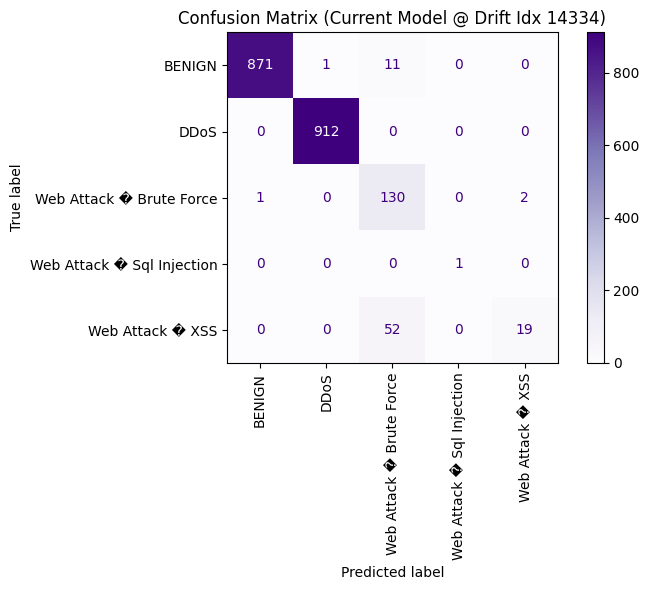


   Retraining XGBoost model (multi-class)...
Model retrained successfully with XGBoost! 

Metrics AFTER retraining on new training data:
  Accuracy : 0.9785
  Precision: 0.9787
  Recall   : 0.9785
  F1-score : 0.9785
  AUC      : 0.9994 

   Resetting centroids and counts based on retrained data...
   Centroids and counts reset. New baseline established for classes: 'BENIGN' (0), 'DDoS' (1), 'Web Attack � Brute Force' (2), 'Web Attack � Sql Injection' (3), 'Web Attack � XSS' (4)
Processing sample 14999... Current Drift Rate: 0.0361 (Classes used for calc: 3)
Processing sample 15999... Current Drift Rate: 0.0448 (Classes used for calc: 4)
Processing sample 16999... Current Drift Rate: 0.0607 (Classes used for calc: 4)
Processing sample 17999... Current Drift Rate: 0.0593 (Classes used for calc: 4)
Processing sample 18999... Current Drift Rate: 0.0535 (Classes used for calc: 4)
Processing sample 19999... Current Drift Rate: 0.0571 (Classes used for calc: 4)
Processing sample 20999... Cu

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


drift_rates = []
drift_indices = []
drift_threshold = 0.17
drift_detected = False
warm_up_samples = 1000
retrain_buffer_size = 1000
min_samples_for_drift_calc = 100
accuracy_log = {}

print(f"Starting drift detection loop with warm-up period of {warm_up_samples} samples...")
print(f"Drift Threshold set to: {drift_threshold}")
print(f"Retraining will use warm-up samples + {retrain_buffer_size} samples preceding drift.")
print(f"Minimum samples per class for inclusion in drift calculation: {min_samples_for_drift_calc}")
print(f"Label mapping being used: {label_mapping}")

for idx in range(len(X_scaled)):
    sample = X_scaled[idx].reshape(1, -1)

    true_label = y.iloc[idx] if isinstance(y, pd.Series) else y[idx]
    pred_label = clf.predict(sample)[0]
    label_to_update = pred_label

    if label_to_update in centroids:
        centroids[label_to_update] = (centroids[label_to_update] * counts[label_to_update] + sample.flatten()) / (counts[label_to_update] + 1)
        counts[label_to_update] += 1
    else:
        class_name = label_mapping.get(label_to_update, f"Unknown({label_to_update})")
        print(f"\nWarning: First occurrence of predicted/true label '{class_name}' ({label_to_update}) at index {idx}. Initializing its centroid.")
        centroids[label_to_update] = sample.flatten()
        counts[label_to_update] = 1

    if idx < warm_up_samples:
        if (idx + 1) % 500 == 0:
            print(f"Warm-up progress: {idx + 1}/{warm_up_samples} samples processed.")
        continue

    current_drift_rate = 0.0
    valid_cls_count_for_drift = 0

    for cls in centroids_initial.keys():
        if cls in centroids and counts.get(cls, 0) >= min_samples_for_drift_calc:
            if cls in centroids_initial:
                 distance = np.linalg.norm(centroids[cls] - centroids_initial[cls])
                 current_drift_rate += distance
                 valid_cls_count_for_drift += 1
            else:
                 print(f"Warning: Class {cls} found in current centroids but not in initial centroids. Skipping for drift calc.")


    if valid_cls_count_for_drift > 0:
        current_drift_rate /= valid_cls_count_for_drift
        drift_rates.append(current_drift_rate)

        if current_drift_rate > drift_threshold and not drift_detected:
            print(f"\nDrift Detected at sample index: {idx} (Drift Rate: {current_drift_rate:.4f})")
            class_dist_str = ", ".join([f"'{label_mapping.get(cls, cls)}': {counts.get(cls, 0)}" for cls in sorted(centroids.keys())])
            print(f"   Current class sample counts: {class_dist_str}")

            drift_indices.append(idx)
            drift_detected = True

            print(f"   Preparing data for retraining...")
            retrain_start_idx = max(0, idx - retrain_buffer_size)
            retrain_buffer_data = X_scaled[retrain_start_idx:idx]
            retrain_buffer_labels = y.iloc[retrain_start_idx:idx].values if isinstance(y, pd.Series) else y[retrain_start_idx:idx]

            X_train_new = np.vstack((X_scaled[:warm_up_samples], retrain_buffer_data))
            warmup_labels = y.iloc[:warm_up_samples].values if isinstance(y, pd.Series) else y[:warm_up_samples]
            y_train_new = np.hstack((warmup_labels, retrain_buffer_labels))

            print(f"   New training data shape: {X_train_new.shape}")
            print(f"   New training labels shape: {y_train_new.shape}")
            print(f"   Unique labels in new training data: {np.unique(y_train_new)}")
            new_labels_text = [label_mapping.get(l, l) for l in np.unique(y_train_new)]
            print(f"   Unique labels (text): {new_labels_text} \n")

            y_pred_before = clf.predict(X_train_new)
            acc_before = accuracy_score(y_train_new, y_pred_before)
            precision_before = precision_score(y_train_new, y_pred_before, average='weighted', zero_division=0)
            recall_before = recall_score(y_train_new, y_pred_before, average='weighted', zero_division=0)
            f1_before = f1_score(y_train_new, y_pred_before, average='weighted', zero_division=0)

            print(f"Metrics BEFORE retraining on new training data:")
            print(f"  Accuracy : {acc_before:.4f}")
            print(f"  Precision: {precision_before:.4f}")
            print(f"  Recall   : {recall_before:.4f}")
            print(f"  F1-score : {f1_before:.4f} \n")
            print("Plotting Confusion Matrix (BEFORE Retraining on New Data)...")
            cm_before = confusion_matrix(y_train_new, y_pred_before)
            display_labels_before = label_encoder.classes_ if 'label_encoder' in locals() else None

            if display_labels_before is not None:
                disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before, display_labels=display_labels_before)
                fig, ax = plt.subplots(figsize=(8, 6))
                disp_before.plot(cmap=plt.cm.Purples, ax=ax, xticks_rotation='vertical')
                plt.title(f"Confusion Matrix (Current Model @ Drift Idx {idx})")
                plt.tight_layout()
                plt.show()
            else:
                 print("Warning: label_encoder not found. Cannot display class names on confusion matrix.")
                 disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before)
                 fig, ax = plt.subplots(figsize=(8, 6))
                 disp_before.plot(cmap=plt.cm.Purples, ax=ax, xticks_rotation='vertical')
                 plt.title(f"Confusion Matrix (Current Model @ Drift Idx {idx} - Numerical Labels)")
                 plt.tight_layout()
                 plt.show()


            print(f"\n   Retraining XGBoost model (multi-class)...")
            clf = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', random_state=42)
            clf.fit(X_train_new, y_train_new)
            print(f"Model retrained successfully with XGBoost! \n")
            y_pred_after = clf.predict(X_train_new)
            y_pred_proba_after = clf.predict_proba(X_train_new)

            acc_after = accuracy_score(y_train_new, y_pred_after)
            precision_after = precision_score(y_train_new, y_pred_after, average='weighted', zero_division=0)
            recall_after = recall_score(y_train_new, y_pred_after, average='weighted', zero_division=0)
            f1_after = f1_score(y_train_new, y_pred_after, average='weighted', zero_division=0)
            n_classes_retrain = len(np.unique(y_train_new))
            if n_classes_retrain > 2:
                 auc_after = roc_auc_score(y_train_new, y_pred_proba_after, multi_class='ovr', average='weighted')
            elif n_classes_retrain == 2:
                 if 1 in clf.classes_:
                     pos_label_idx = list(clf.classes_).index(1)
                     auc_after = roc_auc_score(y_train_new, y_pred_proba_after[:, pos_label_idx])
                 else:
                      auc_after = float('nan')
            else:
                 auc_after = float('nan')

            print(f"Metrics AFTER retraining on new training data:")
            print(f"  Accuracy : {acc_after:.4f}")
            print(f"  Precision: {precision_after:.4f}")
            print(f"  Recall   : {recall_after:.4f}")
            print(f"  F1-score : {f1_after:.4f}")
            if not np.isnan(auc_after):
                print(f"  AUC      : {auc_after:.4f} \n")
            else:
                print(f"  AUC      : Not applicable/calculable \n")

            accuracy_log[idx] = {
                'before': acc_before,
                'after': acc_after,
                'precision_before': precision_before,
                'recall_before': recall_before,
                'f1_before': f1_before,
                'precision_after': precision_after,
                'recall_after': recall_after,
                'f1_after': f1_after,
                'auc_after': auc_after if not np.isnan(auc_after) else None
            }

            print(f"   Resetting centroids and counts based on retrained data...")
            unique_labels_new = np.unique(y_train_new)
            new_centroids = {}
            new_counts = {}

            for cls_retrained in unique_labels_new:
                class_samples_new = X_train_new[y_train_new == cls_retrained]
                if len(class_samples_new) > 0:
                    new_centroids[cls_retrained] = np.mean(class_samples_new, axis=0)
                    new_counts[cls_retrained] = len(class_samples_new)
                else:
                    class_name = label_mapping.get(cls_retrained, cls_retrained)
                    print(f"Warning: Class '{class_name}' ({cls_retrained}) found by unique() but has no samples in X_train_new during reset?")

            centroids = {k: v for k, v in new_centroids.items() if k in unique_labels_new}
            counts = {k: v for k, v in new_counts.items() if k in unique_labels_new}
            centroids_initial = {cls: np.copy(centroids[cls]) for cls in centroids}


            new_baseline_str = ", ".join([f"'{label_mapping.get(cls, cls)}' ({cls})" for cls in sorted(centroids_initial.keys())])
            print(f"   Centroids and counts reset. New baseline established for classes: {new_baseline_str}")

            drift_detected = False



    display_drift_rate = current_drift_rate if 'current_drift_rate' in locals() and valid_cls_count_for_drift > 0 else drift_rates[-1] if drift_rates else 0.0
    display_valid_cls_count = valid_cls_count_for_drift if 'valid_cls_count_for_drift' in locals() and valid_cls_count_for_drift > 0 else 0

    if idx >= warm_up_samples and (idx - warm_up_samples + 1) % 1000 == 0:
         print(f"Processing sample {idx}... Current Drift Rate: {display_drift_rate:.4f} (Classes used for calc: {display_valid_cls_count})")


print("\nDrift detection loop completed.")
drift_was_detected = len(drift_indices) > 0
if drift_was_detected:
    print("Drift was detected at least once during the run.")
    print(f"Drift detected at indices: {drift_indices}")
else:
    final_drift_check = any(dr > drift_threshold for dr in drift_rates) if drift_rates else False
    if final_drift_check:
         print("Drift condition met but retraining might not have triggered (check logic/flags).")
    else:
         print("No significant drift detected above the threshold during the run.")

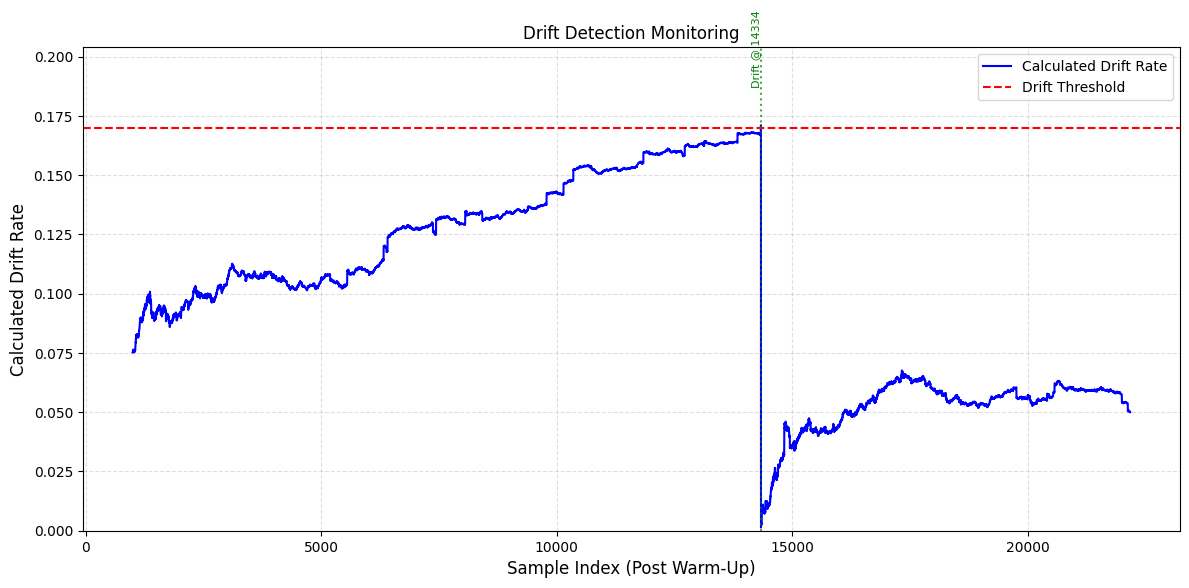

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
if drift_rates:
    valid_samples = range(warm_up_samples, warm_up_samples + len(drift_rates))

    plt.plot(valid_samples, drift_rates, label='Calculated Drift Rate', color='blue')
else:
    print("No drift rates were calculated (possibly due to insufficient samples per class after warm-up). Plotting threshold only.")
    total_samples = len(X_scaled) if 'X_scaled' in locals() else warm_up_samples + 1000
    valid_samples = range(warm_up_samples, total_samples)

plt.axhline(drift_threshold, color='red', linestyle='--', label='Drift Threshold')

for idx in drift_indices:
    if not drift_rates or (idx >= valid_samples.start and idx < valid_samples.stop):
         plt.axvline(idx, color='green', linestyle=':', alpha=0.7)
         text_y_pos = drift_threshold * 1.1 if drift_threshold > 0 else 0.01
         plt.text(idx, text_y_pos, f'Drift @ {idx}', rotation=90,
                 fontsize=8, color='green', ha='right', va='bottom')

plt.xlabel("Sample Index (Post Warm-Up)", fontsize=12)
plt.ylabel("Calculated Drift Rate", fontsize=12)
plt.title("Drift Detection Monitoring", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
if drift_rates:
    min_rate = min(drift_rates)
    max_rate = max(drift_rates)
    plt.ylim(min(0, min_rate * 0.9), max(drift_threshold * 1.2, max_rate * 1.1))
else:
     plt.ylim(0, drift_threshold * 1.2)


plt.tight_layout()
plt.show()


Plotting Confusion Matrix for Model State After Last Retraining Event...


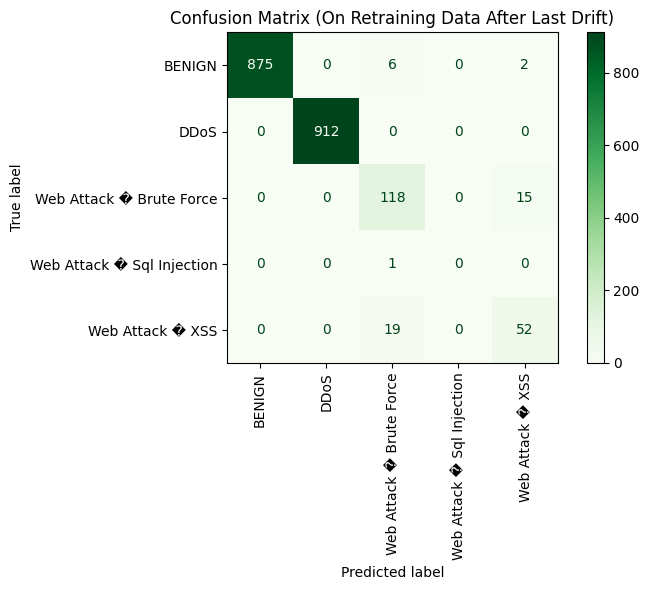

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

print("\nPlotting Confusion Matrix for Model State After Last Retraining Event...")

if 'drift_indices' in locals() and drift_indices:
    if 'y_train_new' in locals() and 'y_pred_after' in locals():
        cm_after_retrain = confusion_matrix(y_train_new, y_pred_after)
        display_labels_retrain = label_encoder.classes_ if 'label_encoder' in locals() else None

        if display_labels_retrain is not None:
            disp_retrain = ConfusionMatrixDisplay(confusion_matrix=cm_after_retrain, display_labels=display_labels_retrain)
            fig, ax = plt.subplots(figsize=(8, 6))
            disp_retrain.plot(cmap=plt.cm.Greens, ax=ax, xticks_rotation='vertical')
            plt.title("Confusion Matrix (On Retraining Data After Last Drift)")
            plt.tight_layout()
            plt.show()
        else:
            print("Warning: label_encoder not found. Cannot display class names on confusion matrix.")
            disp_retrain = ConfusionMatrixDisplay(confusion_matrix=cm_after_retrain)
            fig, ax = plt.subplots(figsize=(8, 6))
            disp_retrain.plot(cmap=plt.cm.Greens, ax=ax, xticks_rotation='vertical')
            plt.title("Confusion Matrix (On Retraining Data After Last Drift - Numerical Labels)")
            plt.tight_layout()
            plt.show()
    else:
        print("Retraining variables (y_train_new, y_pred_after) not found. Cannot plot confusion matrix for last retraining.")
else:
    print("No drift detected requiring retraining during the run. Skipping final retraining confusion matrix.")